## Pobranie potrzebnych paczek

In [19]:
import requests
import os
from pyunpack import Archive
import xml.etree.ElementTree as et
import pandas as pd
import numpy as np
from py7zr import unpack_7zarchive
import matplotlib.pyplot as plt
import shutil
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

## Funkcje potrzebne do pobrania i przygotowania danych

In [2]:
def download_packed(url, name, path):
    filename = path + '\\' + name + '.7z'
    if os.path.exists(filename):
        return filename
    
    response = requests.get(url, stream=True)
    if not os.path.exists(path):
        os.mkdir(path)
    if response.status_code == 200:
        with open(filename, 'wb') as out:
            out.write(response.content)
    else:
        print(f'Request failed with code {response.status_code}')
    return filename

In [3]:
def download_all_packed(urls, names, path):
    filenames = []
    for url, name in zip(urls, names):
        filenames.append(download_packed(url, name, path))
    return filenames

In [4]:
def unpack(archive, path):
    if not os.path.exists(path):
        os.mkdir(path)
    else:
        return archive[:-3]
    try:
        shutil.register_unpack_format('.7z', '.7z', unpack_7zarchive)
    except:
        print("Archive already registered.")
    shutil.unpack_archive(archive, path)
    return archive[:-3]

In [5]:
def unpack_all(archives, path, names):
    files = []
    for archive, name in zip(archives, names):
        files.append(unpack(archive, path + '\\' + name))
    return files

In [6]:
def parse_xml(file, tables):
    data = {}
    for table in tables:
        tree = et.parse(file + '\\' + table + '.xml')
        root = tree.getroot()
        rows = []
        for elem in root:
            rows.append(elem.attrib)
        data[table] = pd.DataFrame(rows)
    return data

In [7]:
def parse_all_xml(files, names, tables):
    dataframes = {}
    for file, name in zip(files, names):
        dataframes[name] = parse_xml(file, tables)
    return dataframes

In [8]:
def adjust_data(df):
    boolean_dict = {'False':False, 'True':True, np.nan:False}
    for col in df:
        if ('Id' in col) or (col == 'Score') or (col == 'Class') or ('Count' in col) or \
        (col == 'Reputation') or ('Views' in col) or ('Votes' in col):
            df[col] = pd.to_numeric(df[col])
        elif ('Date' in col):
            df[col] = pd.to_datetime(df[col])
        elif (col == 'TagBased') or ('Is' in col):
            df[col] = df[col].map(boolean_dict)
    return df

In [9]:
def adjust_all_data(dfs):
    for key in dfs:
        for inner_key in dfs[key]:
            dfs[key][inner_key] = adjust_data(dfs[key][inner_key])
    return dfs

In [10]:
def prepare_data_for_use(urls, names, path, tables):
    archives = download_all_packed(urls, names, path)
    files = unpack_all(archives, path, names)
    dataframes = parse_all_xml(files, names, tables)
    dataframes_adjusted = adjust_all_data(dataframes)
    return dataframes_adjusted

In [16]:
def find_200_most_frequent_words_in_posts(postsXML_directory):
    '''
    Function that find 100 most frequent words in Posts.xml
    postsXML_directory - path to the file Posts.xml ex. 7zdatabase\hinduism.stackexchange.com\Posts.XML
    '''
    xtree = et.parse(postsXML_directory)
    xroot = xtree.getroot()
    df_cols = ["Id", "Body"]
    rows = []
    for node in xroot:
        s_id= node.attrib.get("Id")
        s_body = node.attrib.get("Body")
        # Clean html tags
        if s_body is not None:
            post_text = cleanhtml(s_body)
            # Remove \n sign
            text = re.sub(r'\n', ' ', post_text)
            rows.append({"Id": s_id, "Body": text})
    df = pd.DataFrame(rows, columns = df_cols)
    df_body = df['Body'].str.lower()
    # Make all words lowercase and add them to an array
    words_list = []
    for i in range(df_body.size):
        try:
            words_list.append( '{} '.format(df_body[i].lower()))
        except:
            None
    # Convert list to string
    words = ''
    words = words.join(words_list)
    # Find 200 most common words
    wd = pd.DataFrame(Counter(words.split()).most_common(200), columns=['word', 'frequency'])
    return wd

In [17]:
def show_most_frequent_words_graph(word_frequency_df):
    data = dict(zip(word_frequency_df['word'].tolist(), word_frequency_df['frequency'].tolist()))
    for word in STOPWORDS:
        if data.get(word) : data.pop(word)
    wc = WordCloud(background_color='white',
                stopwords=STOPWORDS,
                max_words=200).generate_from_frequencies(data)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [28]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>|&amp;')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

In [9]:
def words_occurency(postsXML_directory, words):
    '''
    Function that find occurencies of words in Posts.xml.
    '''
    xtree = et.parse(postsXML_directory)
    xroot = xtree.getroot()
    df_cols = ["Id", "Body"]
    rows = []
    for node in xroot:
        s_id= node.attrib.get("Id")
        s_body = node.attrib.get("Body")
        # Clean html tags
        if s_body is not None:
            rows.append({"Id": s_id, "Body": s_body})
    occurencies = 0
    for row in rows:
        for word in words:
            occurencies += row["Body"].count(word)
    return occurencies
            

In [17]:
def words_occurency_list(postsXML_directory, words_list):
    occurency_list = []
    for words in words_list:
        cur_occurency = words_occurency(postsXML_directory, words)
        occurency_list.append(cur_occurency)
    return occurency_list
    

In [30]:
def draw_words_plot(religions, occurencies, title):
    y_pos = np.arange(len(religions))

    plt.bar(y_pos, occurencies, align='center', alpha=0.5)
    plt.xticks(y_pos, religions)
    plt.ylabel('Liczba wystąpień')
    plt.title(title)
    plt.show()

## Wywołanie utworzenia danych

In [11]:
urls = [
    'https://archive.org/download/stackexchange/islam.stackexchange.com.7z',
    'https://archive.org/download/stackexchange/christianity.stackexchange.com.7z',
    'https://archive.org/download/stackexchange/buddhism.stackexchange.com.7z',
    'https://archive.org/download/stackexchange/judaism.stackexchange.com.7z',
    'https://archive.org/download/stackexchange/hinduism.stackexchange.com.7z',
]

names = [
    'islam',
    'christianity',
    'buddhism',
    'judaism',
    'hinduism'
]

tables = [
    'Badges',
    'Comments',
    'PostHistory',
    'PostLinks',
    'Posts',
    'Users',
    'Votes',
    'Tags',
    
]

path = os.getcwd() + '\\' + 'data'

dfs = prepare_data_for_use(urls, names, path, tables)

islam_df = dfs['islam']
christianity_df = dfs['christianity']
buddhism_df = dfs['buddhism']
judaism_df = dfs['judaism']
hinduism_df = dfs['hinduism']

Archive already registered.
Archive already registered.
Archive already registered.
Archive already registered.


 ## Stosunek postów do miesięcy

In [12]:
def get_posts_per_month(df):
    data = df['Posts'].groupby([df['Posts'].CreationDate.dt.month])['CreationDate'].count()
    return data

In [13]:
m1 = get_posts_per_month(islam_df)
m2 = get_posts_per_month(christianity_df)
m3 = get_posts_per_month(buddhism_df)
m4 = get_posts_per_month(judaism_df)
m5 = get_posts_per_month(hinduism_df)

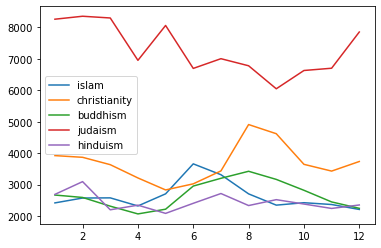

In [14]:
plt.plot(m1)
plt.plot(m2)
plt.plot(m3)
plt.plot(m4)
plt.plot(m5)

plt.legend([
    'islam',
    'christianity',
    'buddhism',
    'judaism',
    'hinduism'
])

plt.show()

In [15]:
## Zestawienie najczęściej występujących słów

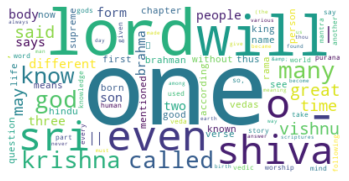

In [22]:
hinduismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'hinduism' + '\\' + 'Posts.XML'
hinduism200Words = find_200_most_frequent_words_in_posts(hinduismPostsPath)
show_most_frequent_words_graph(hinduism200Words)

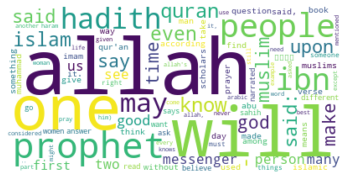

In [23]:
islamPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'islam' + '\\' + 'Posts.XML'
islam200Words = find_200_most_frequent_words_in_posts(islamPostsPath)
show_most_frequent_words_graph(islam200Words)

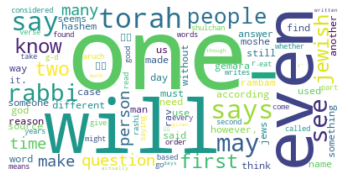

In [24]:
judaismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'judaism' + '\\' + 'Posts.XML'
judaism200Words = find_200_most_frequent_words_in_posts(judaismPostsPath)
show_most_frequent_words_graph(judaism200Words)

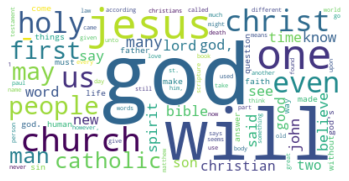

In [25]:
christianityPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'christianity' + '\\' + 'Posts.XML'
christianity200Words = find_200_most_frequent_words_in_posts(christianityPostsPath)
show_most_frequent_words_graph(christianity200Words)

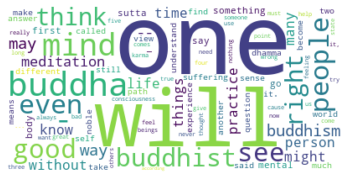

In [29]:
buddhismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'buddhism' + '\\' + 'Posts.XML'
buddhism200Words = find_200_most_frequent_words_in_posts(buddhismPostsPath)
show_most_frequent_words_graph(buddhism200Words)

In [ ]:
hinduism_words = ["hinduism", "shiva", "krishna", "hindu", "brahman"]
islam_words = ["allah", "muslim", "islam", "hadith", "quoran"]
judaism_words = ["rabbi", "torah", "judaism", "jew", "moshe"]
christianity_words = ["jesus", "church", "paul", "christian", "catholic"]
buddhism_words = ["buddha", "buddhist", "buddhism", "sutta", "budd"]


hinduismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'hinduism' + '\\' + 'Posts.XML'
islamPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'islam' + '\\' + 'Posts.XML'
judaismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'judaism' + '\\' + 'Posts.XML'
christianityPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'christianity' + '\\' + 'Posts.XML'
buddhismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'buddhism' + '\\' + 'Posts.XML'
h_w = words_occurency_list(hinduismPostsPath, [islam_words, judaism_words, christianity_words, buddhism_words])

pl1 = draw_words_plot(["islam", "judaism", "christianity", "buddhism"], h_w, "Występowanie słów z innych religi w postach forum hinduistycznego")


In [ ]:
hinduism_words = ["hinduism", "shiva", "krishna", "hindu", "brahman"]
islam_words = ["allah", "muslim", "islam", "hadith", "quoran"]
judaism_words = ["rabbi", "torah", "judaism", "jew", "moshe"]
christianity_words = ["jesus", "church", "paul", "christian", "catholic"]
buddhism_words = ["buddha", "buddhist", "buddhism", "sutta", "budd"]

hinduismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'hinduism' + '\\' + 'Posts.XML'
islamPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'islam' + '\\' + 'Posts.XML'
judaismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'judaism' + '\\' + 'Posts.XML'
christianityPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'christianity' + '\\' + 'Posts.XML'
buddhismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'buddhism' + '\\' + 'Posts.XML'

i_w = words_occurency_list(islamPostsPath, [hinduism_words, judaism_words, christianity_words, buddhism_words])
pl2 = draw_words_plot(["hinduism", "judaism", "christianity", "buddhism"], i_w, "Występowanie słów z innych religi w postach forum islamistycznego")



In [ ]:
hinduism_words = ["hinduism", "shiva", "krishna", "hindu", "brahman"]
islam_words = ["allah", "muslim", "islam", "hadith", "quoran"]
judaism_words = ["rabbi", "torah", "judaism", "jew", "moshe"]
christianity_words = ["jesus", "church", "paul", "christian", "catholic"]
buddhism_words = ["buddha", "buddhist", "buddhism", "sutta", "budd"]

hinduismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'hinduism' + '\\' + 'Posts.XML'
islamPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'islam' + '\\' + 'Posts.XML'
judaismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'judaism' + '\\' + 'Posts.XML'
christianityPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'christianity' + '\\' + 'Posts.XML'
buddhismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'buddhism' + '\\' + 'Posts.XML'

j_w = words_occurency_list(judaismPostsPath, [hinduism_words, islam_words, christianity_words, buddhism_words])
pl3 = draw_words_plot(["hinduism", "islam", "christianity", "buddhism"], j_w, "Występowanie słów z innych religi w postach forum judaistycznego")



In [ ]:
hinduism_words = ["hinduism", "shiva", "krishna", "hindu", "brahman"]
islam_words = ["allah", "muslim", "islam", "hadith", "quoran"]
judaism_words = ["rabbi", "torah", "judaism", "jew", "moshe"]
christianity_words = ["jesus", "church", "paul", "christian", "catholic"]
buddhism_words = ["buddha", "buddhist", "buddhism", "sutta", "budd"]

hinduismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'hinduism' + '\\' + 'Posts.XML'
islamPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'islam' + '\\' + 'Posts.XML'
judaismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'judaism' + '\\' + 'Posts.XML'
christianityPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'christianity' + '\\' + 'Posts.XML'
buddhismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'buddhism' + '\\' + 'Posts.XML'

c_w = words_occurency_list(christianityPostsPath, [hinduism_words, islam_words, judaism_words, buddhism_words])
pl4 = draw_words_plot(["hinduism", "islam", "judaism", "buddhism"], c_w, "Występowanie słów z innych religi w postach forum chrześcijańskiego")


In [ ]:
hinduism_words = ["hinduism", "shiva", "krishna", "hindu", "brahman"]
islam_words = ["allah", "muslim", "islam", "hadith", "quoran"]
judaism_words = ["rabbi", "torah", "judaism", "jew", "moshe"]
christianity_words = ["jesus", "church", "paul", "christian", "catholic"]
buddhism_words = ["buddha", "buddhist", "buddhism", "sutta", "budd"]

hinduismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'hinduism' + '\\' + 'Posts.XML'
islamPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'islam' + '\\' + 'Posts.XML'
judaismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'judaism' + '\\' + 'Posts.XML'
christianityPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'christianity' + '\\' + 'Posts.XML'
buddhismPostsPath = os.getcwd() + '\\' + 'data' + '\\' + 'buddhism' + '\\' + 'Posts.XML'

b_w = words_occurency_list(buddhismPostsPath, [hinduism_words, islam_words, judaism_words, christianity_words])
pl5 = draw_words_plot(["hinduism", "islam", "judaism", "christianity"], b_w, "Występowanie słów z innych religi w postach forum buddyjskiego")